In [149]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

from mutspec.utils import CodonAnnotation, possible_sbs12, possible_codons, possible_nucls

In [11]:
coda = CodonAnnotation(5)

In [63]:
# _path = "../data/processed/nematoda/22-05-22-15-51-30/mutspec12.tsv"
# edge_mutspec = pd.read_csv(_path, sep='\t')
# ms = edge_mutspec[(edge_mutspec.Label == "syn") & (edge_mutspec.AltNode == "Philometroides_sanguineus")].sort_values("Mut")
# print(ms.shape)
# ms
ms = pd.read_csv("../data/raw/07.FF_MutSpec_12comp.csv", index_col=0)
ms["MutSpec"] = ms["MutSpec"] / ms["MutSpec"].sum()
ms = ms.rename({"NucSubst": "Mut"}, axis=1)
ms["Mut"] = ms["Mut"].str.replace("U", "T")
ms

,Mut,ExpFr,ObsFr,MutSpec
1,A>C,1230,1445,0.008664
2,A>G,1230,7056,0.042305
3,A>T,1230,2838,0.017016
4,C>A,582,1388,0.017588
5,C>G,582,502,0.006361
6,C>T,582,25475,0.322800
7,G>A,277,7276,0.193711
8,G>C,277,485,0.012912
9,G>T,277,9508,0.253134
10,T>A,2160,2645,0.009031


In [13]:
def find_loosers_gainers(df: pd.DataFrame):
    '''
    https://hmmlearn.readthedocs.io/en/latest/tutorial.html

    https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e

    https://ipython-books.github.io/131-simulating-a-discrete-time-markov-chain/

    #cool?
    https://python.quantecon.org/finite_markov.html

    #code
    https://github.com/vbelz/Markov-chain-simulation
    https://github.com/maximtrp/mchmm

    #drawing
    https://naysan.ca/2020/07/08/drawing-state-transition-diagrams-in-python/
    https://stackoverflow.com/questions/62044102/how-to-visually-animate-markov-chains-in-python

    #online simulator
    http://markov.yoriz.co.uk/
    '''
    assert "Mut" in df.columns
    assert "MutSpec" in df.columns

    sbs_freqs = df.set_index("Mut").MutSpec.to_dict()
    
    
    return

In [64]:
sbs_freqs = ms.set_index("Mut").MutSpec.to_dict()
sbs_freqs

{'A>C': 0.008663722138708072,
 'A>G': 0.04230534492091637,
 'A>T': 0.017015670193531826,
 'C>A': 0.01758766808652655,
 'C>G': 0.006360957766164506,
 'C>T': 0.3227995997869334,
 'G>A': 0.1937111863538531,
 'G>C': 0.01291230420308119,
 'G>T': 0.253134408995662,
 'T>A': 0.009030539670628595,
 'T>C': 0.08924699697173226,
 'T>G': 0.02723160091226217}

In [122]:
def get_codon_sbs(sbs_freqs):
    codon_sbs_freqs = dict()
    for cdn in possible_codons:
        for i in range(2):
            for nucl in possible_nucls:
                if nucl == cdn[i]:
                    continue
                cdn_alt = nucl + cdn[1:] if i == 0 else cdn[0] + nucl + cdn[-1]
                sbs = cdn[i] + ">" + nucl
                proba = sbs_freqs[sbs]
                codon_sbs_freqs[f"{cdn}>{cdn_alt}"] = proba
    return codon_sbs_freqs


def get_codon_transition_matrix(codon_sbs_freqs: dict):
    n = len(possible_codons)
    matrix = np.zeros((n, n))
    for i, cdn1 in enumerate(possible_codons):
        for j, cdn2 in enumerate(possible_codons):
            csbs = f"{cdn1}>{cdn2}"
            proba = codon_sbs_freqs.get(csbs, 0)
            matrix[i, j] = proba
    matrix = matrix / matrix.sum(axis=1).reshape(-1, 1)
    return matrix

In [123]:
codon_sbs_freqs = get_codon_sbs(sbs_freqs)
tmatrix = get_codon_transition_matrix(codon_sbs_freqs)

In [148]:
codon_sbs_freqs

{'AAA>CAA': 0.008663722138708072,
 'AAA>GAA': 0.04230534492091637,
 'AAA>TAA': 0.017015670193531826,
 'AAA>ACA': 0.008663722138708072,
 'AAA>AGA': 0.04230534492091637,
 'AAA>ATA': 0.017015670193531826,
 'AAC>CAC': 0.008663722138708072,
 'AAC>GAC': 0.04230534492091637,
 'AAC>TAC': 0.017015670193531826,
 'AAC>ACC': 0.008663722138708072,
 'AAC>AGC': 0.04230534492091637,
 'AAC>ATC': 0.017015670193531826,
 'AAG>CAG': 0.008663722138708072,
 'AAG>GAG': 0.04230534492091637,
 'AAG>TAG': 0.017015670193531826,
 'AAG>ACG': 0.008663722138708072,
 'AAG>AGG': 0.04230534492091637,
 'AAG>ATG': 0.017015670193531826,
 'AAT>CAT': 0.008663722138708072,
 'AAT>GAT': 0.04230534492091637,
 'AAT>TAT': 0.017015670193531826,
 'AAT>ACT': 0.008663722138708072,
 'AAT>AGT': 0.04230534492091637,
 'AAT>ATT': 0.017015670193531826,
 'ACA>CCA': 0.008663722138708072,
 'ACA>GCA': 0.04230534492091637,
 'ACA>TCA': 0.017015670193531826,
 'ACA>AAA': 0.01758766808652655,
 'ACA>AGA': 0.006360957766164506,
 'ACA>ATA': 0.3227995997

In [125]:
tmatrix[0].sum()

1.0000000000000002

In [147]:
tmatrix.min()

0.0

In [144]:
model = hmm.GaussianHMM(n_components=len(possible_codons), covariance_type="full", n_iter=100)
# model.startprob_ = np.array(np.ones(len(possible_codons)) / len(possible_codons))
# model.startprob_ = np.random.random(len(possible_codons))
# model.startprob_ = model.startprob_ / model.startprob_.sum()
model.transmat_ = tmatrix


In [157]:
stationar = model.get_stationary_distribution()
stationar_dct = dict(zip(possible_codons, stationar))
print(stationar_dct)

{'AAA': 0.0034042701638609045, 'AAC': -0.053998350091357394, 'AAG': -0.18128223965496104, 'AAT': 0.26327249980186596, 'ACA': 0.005484596296942402, 'ACC': -0.0869963712328733, 'ACG': -0.2920625721391008, 'ACT': 0.4241565175495096, 'AGA': 0.002818322654128731, 'AGC': -0.04470408223286664, 'AGG': -0.15007969938308643, 'AGT': 0.21795768687159545, 'ATA': 0.009321989713445415, 'ATC': -0.14786489904316932, 'ATG': -0.4964092424962877, 'ATT': 0.7209250197123321, 'CAA': 0.005484596296944849, 'CAC': -0.0869963712328723, 'CAG': -0.2920625721390996, 'CAT': 0.42415651754950995, 'CCA': 0.004844108556283039, 'CCC': -0.07683698916720143, 'CCG': -0.2579556868127981, 'CCT': 0.37462378352436937, 'CGA': 0.0022749387659588213, 'CGC': -0.036084956248405665, 'CGG': -0.12114373264173457, 'CGT': 0.1759345724579691, 'CTA': 0.012017486639084694, 'CTC': -0.19062072618224576, 'CTG': -0.6399482967258815, 'CTT': 0.9293838610094627, 'GAA': 0.002818322654129476, 'GAC': -0.04470408223286619, 'GAG': -0.15007969938308519,

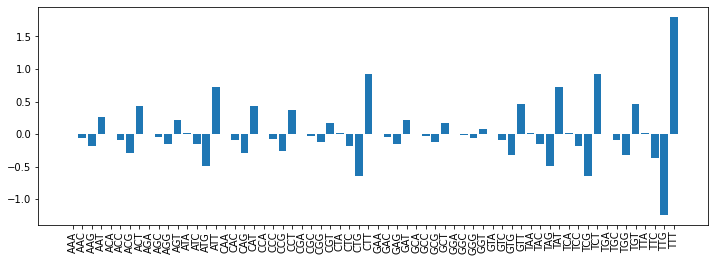

In [168]:
plt.figure(figsize=(12, 4))
plt.bar(possible_codons, stationar)
plt.xticks(rotation=90)
plt.show()

In [174]:
# Leu
prefix = "CT"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

CTA : 0.012017486639084694
CTC : -0.19062072618224576
CTG : -0.6399482967258815
CTT : 0.9293838610094627


In [175]:
# Ser
prefix = "TC"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

TCA : 0.012017486639084297
TCC : -0.19062072618224596
TCG : -0.6399482967258807
TCT : 0.929383861009464


In [173]:
# Phe + Leu
prefix = "TT"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

TTA : 0.023270490469382864
TTC : -0.3691152672027366
TTG : -1.2391867939694734
TTT : 1.7996457104168244


In [176]:
prefix = "AA"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

AAA : 0.0034042701638609045
AAC : -0.053998350091357394
AAG : -0.18128223965496104
AAT : 0.26327249980186596


In [160]:
# stationar_aa = defaultdict(int)
# for cdn, val in zip(possible_codons, stationar):
#     aa = coda.translate_codon(cdn)
#     stationar_aa[aa] += val

# df = pd.Series(stationar_aa).reset_index(name="n")
# df = df.rename({"index": "aa"}, axis=1).sort_values("n")
# df